# WaveNet

[paper] \
https://arxiv.org/pdf/1609.03499.pdf \
The WaveNet proposed by Aaron van den Oord in 2016 autoregressively generates audio. Its novelty comes from convolutional architecture to train on temporal data.

[implementation] \
https://github.com/vincentherrmann/pytorch-wavenet/blob/master/audio_data.py \
_(Implementation details are heavily inspired by the above github repo)_

In [1]:
# import

import os
import bisect
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import librosa
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from scipy.io.wavfile import write

## Preprocess
* quantization ($\mu$-law companding transformation)
* ~~normalization~~

### $\mu$-law companding transformation

$$f(x_t) = sign(x_t) {{\ln (1 + \mu |x_t|)}\over{\ln (1 + \mu)}}, \quad -1 \leq x \leq 1$$
$$f^{-1}(y_t) = sign(y_t) {{(1 + \mu)^{|y_t|} - 1}\over{\mu}}, \quad -1 \leq y \leq 1$$
$\mu$-law companding transformation function and its inverse function. This allows to perform tractable classificaiton task

In [2]:
# 16 bit: −32,768 to 32,767.


def mu_law_companding_transformation(x, mu=255):
    return np.sign(x) * (np.log(1 + mu * np.abs(x)) / np.log(1 + mu))


def inverse_mu_law_companding_transformation(y, mu=255):
    return np.sign(y) * (((1 + mu) ** np.abs(y) - 1) / mu)

# quantize to 8bit
def quantize(wav, bit):
    wav = mu_law_companding_transformation(wav, 2**bit - 1)
    return ((wav + 1) * 2**(bit - 1)).astype(int)

# recover to 16bit
def inv_quantize(wav, bit):
    wav = (wav / 2**(bit - 1) - 1).astype(float)
    return inverse_mu_law_companding_transformation(wav, bit**2 - 1)

11025


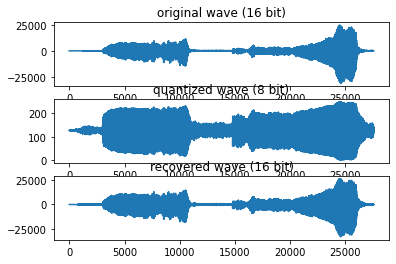

In [3]:
wav, sr = librosa.load("../input/freesound-audio-ds-project/ProcessedAudio/baby cry/1.wav",sr=11025)
print(sr)
quantized_wav = quantize(wav, 8)
recovered_wav = inv_quantize(quantized_wav, 8)

fig, ax = plt.subplots(3, 1)
ax[0].set_title("original wave (16 bit)")
ax[0].plot(wav * 32_767)
ax[1].set_title("quantized wave (8 bit)")
ax[1].plot(quantized_wav)
ax[2].set_title("recovered wave (16 bit)")
ax[2].plot(recovered_wav * 32_767)

## Data

The notebook is currently trained on audio-cats-and-dogs but will be trained on VCTK in the end. The below is the list of dataset tried with the notebook.
* ~~audio-mnist~~
* audio-cats-and-dogs

_[Jan 20, 2022] Changed dataset to audio-cats-and-dogs from audio-mnist as the training on audio-mnist results in generating signals with no sound. I posit the reason to be the long tail and head with no sound for each data._

### Preparing data for training
Format input(src) and label(tgt) in the following way.

<img src="https://i.ibb.co/Yp2KG8B/src-tgt-drawio.png" width="600"/>

One-hot encoding is applied to the src. Thus, the shape of src is [N, C, L] and label is [N, L].

In [4]:
# recursively locate all the wav files

def get_files(dir_):
    def _get_files(fps, dir_):
        _, ds, fs = next(os.walk(dir_))
        for f in fs:
            if f.split('.')[-1] == 'wav':
                fps.append(os.path.join(dir_, f))
        for d in ds:
            _get_files(fps, os.path.join(dir_, d))
            
    files = []
    _get_files(files, dir_)
    return files

files = get_files("../input/freesound-audio-ds-project/ProcessedAudio/baby cry")

In [5]:
# create dataset in ndarray format
# preprocess applied accordingly

def create_dataset(dataset_path, files, sr=11025):
    dataset = []
    for f in tqdm(files):
        wav, _ = librosa.load(f, sr=sr)
#         wav = librosa.util.normalize(wav)
        quantized_wav = quantize(wav, 8)    # 8 bit
        quantized_wav = np.clip(quantized_wav, 0, 2**8 - 1)
        dataset.append(quantized_wav)
    np.savez(dataset_path, *dataset)
    
create_dataset("dataset", files[:1])    # TODO: files[x: y] -> files

  0%|          | 0/1 [00:00<?, ?it/s]

In [6]:
class MNISTAudio(Dataset):
    def __init__(
        self, 
        path="dataset.npz", 
        src_len=1024+64, 
        tgt_len=64, 
        num_class=256
    ):
        self.path = path
        self.src_len = src_len
        self.tgt_len = tgt_len
        self.num_class = num_class
        
        self.dataset_index = self.index_dataset()
        
    def index_dataset(self):
        # locate starting index of audio
        dataset_index = [0]
        dataset = np.load(self.path, mmap_mode='r')
        for i in range(len(dataset)):
            dataset_index.append(dataset_index[-1] 
                                 + dataset['arr_' + str(i)].shape[0])
        return dataset_index
    
    def __getitem__(self, idx):
        d_idx = bisect.bisect_right(self.dataset_index, idx)
        dataset = np.load(self.path, mmap_mode='r')
        
        if idx + self.src_len + 1 <= self.dataset_index[d_idx]:
            start_pos = idx - self.dataset_index[d_idx - 1]
            end_pos = start_pos + self.src_len + 1
            data = dataset['arr_' + str(d_idx - 1)][start_pos: end_pos]
        else:
            start_pos = idx - self.dataset_index[d_idx - 1]
            end_pos = idx + self.src_len + 1 - self.dataset_index[d_idx]
            data = np.concatenate((dataset['arr_' + str(d_idx - 1)][start_pos: ], 
                                   dataset['arr_' + str(d_idx)][: end_pos]))
            
        src = torch.tensor(data[: self.src_len])
        src = F.one_hot(src, self.num_class).type(torch.float).transpose(0, 1)
        tgt = torch.tensor(data[-self.tgt_len:])
        
        return {"src": src, "tgt": tgt}
        
    def __len__(self):
        return self.dataset_index[-1] - self.src_len
    


In [7]:
# dataset2 = MNISTAudio("dataset.npz", 64, 32, 256)
# sum((dataset[0]['src'] == dataset2[0]['src']))
# # index = torch.tensor([[1, 2, 3]])/

In [8]:

# print(dataset.dataset_index)
# print(len(dataset.dataset_index))
## check with float value if aligned correctly
# print(dataset[0])
# print(dataset.dataset['arr_0'][: 20])
# print(dataset[18282])
# print(dataset.dataset['arr_1'][: 20])
# print(dataset[18272])
# print(dataset[18272]['src'][:, 0])
# print(dataset[18272]['src'].size())
# print(np.concatenate((dataset.dataset['arr_0'][-10: ], dataset.dataset['arr_1'][: 10])))

# for i in np.linspace(0, 1468083, 1000):
#     i = int(i)
#     if dataset[i]['src'].size()[-1] != 64:
#         print("error")
#         print(dataset[i]['src'].size())
#         print(dataset[i]['tgt'].size())
#         print(i)
#         break

# dataloader = DataLoader(dataset, batch_size=2)
# batch = next(iter(dataloader))
# batch['src'].size()

## Model

### Dilated Causal Convolution
<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-05-24_at_12.11.35_AM_RLzUMeS.png" width="400"/>



[link] https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

[link2] https://discuss.pytorch.org/t/causal-convolution/3456/4


In [9]:
# dilated causal convolution

class CausalConv1d(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 kernel_size, 
                 dilation=1, 
                 **kwargs):
        super(CausalConv1d, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, 
                              out_channels, 
                              kernel_size, 
                              padding=self.padding, 
                              dilation=dilation, 
                              bias=False, 
                              **kwargs)
    
    def forward(self, input_):
        return self.conv(input_)[:, :, :-self.padding] if self.padding else self.conv(input_)


# cc = CausalConv1d(1, 1, 2, dilation=2, bias=False)
# x = torch.arange(1, 11, dtype=torch.float).view(2, 1, 5)
# x[:, :, [1, 3]] = 0.0
# print(x[0])
# cc(x[:1])


### Gated Activation Units

$$z = \tanh (W_{f, k} * x) \odot \sigma (W_{g, k} * x)$$

In [10]:
# gated activation units
class GatedActivationUnit(nn.Module):
    def __init__(self):
        super(GatedActivationUnit, self).__init__()
    
    def forward(self, input_):
        return torch.tanh(input_) * torch.sigmoid(input_)


# actv = GatedActivationUnit()
# actv(torch.ones(1))


### WaveNet Model


<img src="https://nvidia.github.io/OpenSeq2Seq/html/_images/wavenet.png" width=400>

_make sure to show dimension_

In [11]:
class WaveNet(nn.Module):
    def __init__(
        self,
        num_block=4,
        num_layer=10,
        class_dim=256,
        residual_dim=32,
        dilation_dim=32,
        skip_dim=256,
        kernel_size=2,
        bias=False
    ):
        super(WaveNet, self).__init__()
        self.start_conv = nn.Conv1d(in_channels=class_dim, 
                                    out_channels=residual_dim, 
                                    kernel_size=1, 
                                    bias=bias)
        
        self.stack = nn.ModuleList()
        for b in range(num_block):
            dilation = 1
            for k in range(num_layer):
                
                layer = nn.Sequential(
                    CausalConv1d(in_channels=residual_dim,
                                 out_channels=dilation_dim, 
                                 kernel_size=kernel_size,
                                 dilation=dilation),
                    GatedActivationUnit(),
                    nn.Conv1d(in_channels=dilation_dim, 
                              out_channels=residual_dim, 
                              kernel_size=1, 
                              bias=bias)
                )
                
                self.stack.append(layer)
                dilation *= 2
        
        self.end_conv = nn.Sequential(
            nn.ReLU(), 
            nn.Conv1d(in_channels=residual_dim, 
                      out_channels=skip_dim, 
                      kernel_size=1, 
                      bias=bias),
            nn.ReLU(),
            nn.Conv1d(in_channels=skip_dim, 
                      out_channels=class_dim, 
                      kernel_size=1, 
                      bias=bias)
        )
        
        
    def forward(self, input_):
        residual = self.start_conv(input_)
        skips = torch.zeros_like(residual)
        
        for layer in self.stack:
            skip = layer(residual)
            residual = residual + skip
            skips = skips + skip
        logit = self.end_conv(skips)
        return logit

    
        

In [12]:
# n, c, l = 1, 2, 3
# x = torch.zeros(n, c, l)
# # x = 
# # output...
# # softmax
# # sample from the index
# n, c, l
# logit = torch.randn(32, 256, 10)
# i = 0
# dist = F.softmax(logit[:, :, i], 1)
# print(dist.size())
# torch.multinomial(dist, num_samples=1).size()

# # ...

In [13]:
# x = torch.zeros(1, 256, 100).scatter_(1, torch.tensor(quantized_wav[:100]).view(1, 1, -1), 1.0)
# print(x.size())
# model = WaveNet()
# model(x).size()

In [14]:
# k = torch.zeros(1, 1, 6)
# k[0, 0, [1]] = 1
# print(k)
# c = CausalConv1d(1, 1, 3, 2, bias=False)
# c(k)

## Train

Classification Task: Train with softmax loss

In [15]:

def save_ckpt(path, model, optimizer, misc):
    model.eval()
    model.cpu()
    torch.save({
        'last_epoch': misc['epoch'],
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'losses': misc['losses'],
    }, path)
    

def generate_audio(model, audio_num, audio_len, num_class, receptive_field=1024):
    model.eval()
    n, c, l = audio_num, num_class, audio_len
    device = next(model.parameters()).device
    input_ = torch.zeros(n, c, 1, device=device)   # [N, C, L + 1]
    
    for i in tqdm(range(l)):
        pred = model(input_[:, :, -receptive_field: ])
        dist = F.softmax(pred[:, :, -1], dim=1)
        sample = torch.multinomial(dist, num_samples=1)
        one_hot = F.one_hot(sample.view(n, 1), num_class).type(torch.float).permute(0, 2, 1)
        input_ = torch.cat((input_, one_hot), dim=-1)
#         input_ = torch.cat((input_, torch.zeros(n, c, 1, device=device).scatter_(1, sample.view(n, 1, 1), 1.0)), -1)
        
    audio = input_.argmax(1).to('cpu').numpy()
    audio = inv_quantize(audio, 8)
    return audio

# audio = generate_audio(model, 1, 100, 256)
# plt.plot(audio[0])

In [16]:
from dataclasses import dataclass

@dataclass
class Option:
    DEVICE: str = 'cuda'
    epoch: int = 20
    lr: float = 1e-3
    batch_sz: int = 128
    num_class: int = 256
    clip: float = 1.0
    max_itr: int = 1_000
    
    src_len:int = 1024 + 64
    tgt_len:int = 64
    
    num_block: int = 4
    num_layer: int = 10
    residual_dim: int = 32
    dilation_dim: int = 128
    skip_dim: int = 256
    kernel_size: int = 2
    bias: bool = False
    
    loss_update_itr: int = 100
    ckpt_path: str = ""
    dataset_path: str = "dataset.npz"
    ckpt_dir: str = "ckpt"

opt = Option()
os.makedirs(opt.ckpt_dir, exist_ok=True)

# prepare dataset and dataloader
dataset = MNISTAudio(opt.dataset_path, opt.src_len, opt.tgt_len, opt.num_class)    # TODO: give parameter accordingly
dataloader = DataLoader(dataset, 
                        batch_size=opt.batch_sz, 
                        shuffle=True, 
                        num_workers=2)
pbar = tqdm(range(opt.epoch * min(opt.max_itr, len(dataloader))))

# prepare model
model = WaveNet(    
    num_block = opt.num_block,
    num_layer = opt.num_layer,   # 10,
    class_dim = opt.num_class,
    residual_dim = opt.residual_dim,
    dilation_dim = opt.dilation_dim,
    skip_dim = opt.skip_dim,
    kernel_size = opt.kernel_size,
    bias=opt.bias
)

# prepare optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=opt.lr)

losses = []
last_epoch = 0

# load from checkpoint
if opt.ckpt_path:
    ckpt = torch.load(opt.ckpt_path)
    model.load_state_dict(ckpt['model_state_dict'])
    optimizer.load_state_dict(ckpt['optimizer_state_dict'])
    losses = ckpt['losses']
    last_epoch = ckpt['last_epoch']

    
# train

for e in range(last_epoch, opt.epoch):
    model.train()          # save_ckpt set model mode to eval and cpu
    model.to(opt.DEVICE)
    accum_loss = 0
    
    for idx, batch in enumerate(dataloader):
        src, tgt = batch['src'].to(opt.DEVICE), batch['tgt'].to(opt.DEVICE)
        pred = model(src)[:, :, -opt.tgt_len: ]
        loss = loss_fn(pred, tgt)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), opt.clip)
        optimizer.step()

        accum_loss += loss.item()
        pbar.update()
        
        if idx == opt.max_itr:
            break

        if (idx + 1) % opt.loss_update_itr == 0:
            avg_loss = accum_loss / opt.loss_update_itr
            losses.append(avg_loss)
            accum_loss = 0
            pbar.set_description(f"Epoch {round(e + idx / min(opt.max_itr, len(dataloader)), 2)} | Loss: {round(avg_loss, 5)}")
    print()    # new line for pbar
    # save checkpoint
    save_ckpt(os.path.join(opt.ckpt_dir, str(e) + '.pt'), model, optimizer, {"epoch": e + 1, "losses": losses})

  0%|          | 0/15000 [00:00<?, ?it/s]

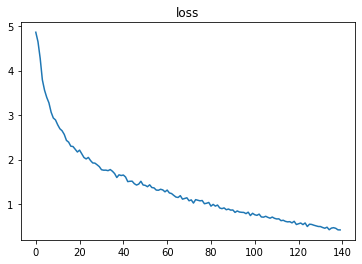

In [17]:
plt.title("loss")
plt.plot(losses)

  0%|          | 0/40000 [00:00<?, ?it/s]

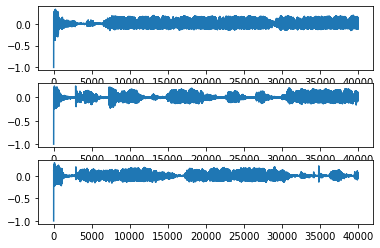

In [18]:
model.to(opt.DEVICE)
audio = generate_audio(model, 16, 40_000, 256)
fig, ax = plt.subplots(3, 1)

for i in range(3):
    ax[i].plot(audio[i])
    write(f'output_{i}.wav', 11025, audio[i])

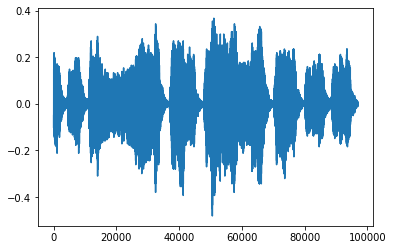

In [19]:
plt.plot(inv_quantize(np.load("dataset.npz")["arr_0"], 8))
write('audio_0.wav', 11025, inv_quantize(np.load("dataset.npz")["arr_0"], 8))


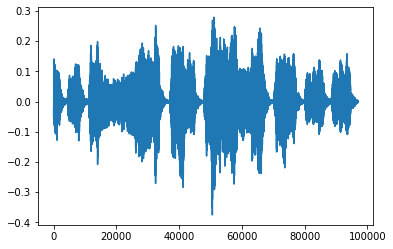

In [20]:
wav, _ = librosa.load(files[0], sr=11025)
plt.plot(wav)
# write('audio_0.wav', 11025, wav)